In [1]:
pip install ta


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
pip install plotly


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
pip install pandas

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
import yfinance as yf #getting data
import pandas as pd #data handling
import numpy as np #calc
import ta #tech indi
import matplotlib.pyplot as plt #visualization


In [5]:
class Backtest:

  def __init__(self,symbol):
    self.symbol=symbol
    self.df=yf.download(self.symbol, start='2019-01-01')

    if self.df.empty:
      print(self.symbol,'no data pulled')
    else:
      # results=pd.DataFrame()
      self.calc_indicators()
      self.generate_signal()
      self.backtest_dataframe()
      self.get_results_dataframe()


      # self.profit=self.calc_profit()
      # # self.max_drawdown= self.profit.min()
      # self.cumul_profit=(self.profit+1).prod()-1
      # # self.plot_chart()

  def calc_indicators(self):
    self.df['ma_20']=self.df.Close.rolling(20).mean()
    self.df['vol']=self.df.Close.rolling(20).std()
    self.df['upper_bb']=self.df.ma_20+(2*self.df.vol)
    self.df['lower_bb']=self.df.ma_20-(2*self.df.vol)
    self.df['rsi']=ta.momentum.rsi(self.df.Close,window=6)
    self.df.dropna(inplace=True)
    self.df.reset_index(inplace=True)

  def generate_signal(self):
    #buy signal
    self.df['signal'] = np.where(
        (self.df['rsi'] < 30) &
        (self.df['Close'] < self.df['lower_bb']), 1, np.nan)

    #sell signal
    self.df['signal'] = np.where(
        (self.df['rsi'] > 70) &
        (self.df['Close'] > self.df['upper_bb']), -1, self.df['signal'])

    #buy/sell next trading day
    self.df['signal'] = self.df['signal'].shift()
    self.df['signal'] = self.df['signal'].fillna(0)



  def plot_chart(self):
    # plt.figure(figsize=(10,5))
    # plt.plot(self.df.Close)

    # plt.scatter(self.buy_arr.index,self.buy_arr.values,marker='^',c='g')
    # plt.scatter(self.sell_arr.index,self.sell_arr.values,marker='v',c='r')

    plt.figure(figsize=(12,5))
# plt.xticks(rotation=45)

    plt.plot(self.df['Date'], self.df['Close'])
    plt.scatter(self.df[(self.df['signal'] == 1)]['buy_date'], self.df[(self.df['signal'] == 1)]['Close'], label = 'Buy', marker='^', c='g')
    plt.scatter(self.df[(self.df['signal'] == -1)]['sell_date'], self.df[(self.df['signal'] == -1)]['Close'], label = 'Sell', marker='v', c='r')
    plt.title('Price Chart & Historical Trades', fontweight="bold")
    return plt
# plt.legend()
# plt.show()

  def backtest_dataframe(self):
    trade_points=pd.DataFrame(columns=["Action","Price","Date"])
    position = 0
    net_profit = 0
    percentage_change = []
    self.df['buy_date'] = ''
    self.df['sell_date'] = ''

    for i in self.df.index:
        close = self.df["Close"][i]
        date = self.df['Date'][i]

        # Buy action
        if self.df["signal"][i] == 1:
            if(position == 0):
                buy_price = close
                position = 1
                self.df.at[i, 'buy_date'] = date
                new_trade = pd.DataFrame([{"Action": "Buy", "Price": np.round(buy_price, 2), "Date": date}])
                trade_points = pd.concat([trade_points, new_trade], ignore_index=True)
                #print(f"Buying at {str(buy_price)} on {str(date)}")

        # Sell action
        elif (self.df["signal"][i] == -1):
            if(position == 1):
                sell_price = close
                bought = 0
                position = 0
                self.df.at[i, 'sell_date'] = date
                new_trade = pd.DataFrame([{"Action": "Sell", "Price": np.round(sell_price, 2), "Date": date}])
                trade_points = pd.concat([trade_points, new_trade], ignore_index=True)
                #print(f"Selling at {str(sell_price)} on {str(date)}")

                # Get percentage change of trade
                pc = (sell_price/buy_price-1)*100
                percentage_change.append(pc)
                net_profit += (sell_price - buy_price)

    # Calculate trade statistics
    gains = 0
    ng = 0
    losses = 0
    nl = 0
    totalR = 1

    for i in percentage_change:
        if(i > 0):
            gains += i
            ng += 1
        else:
            losses += i
            nl += 1
        totalR = totalR * ((i/100)+1)

    totalR = round((totalR-1)*100, 2)

    if(ng > 0):
        avgGain = round(gains/ng, 2)
        maxR = round(max(percentage_change), 2)
    else:
        avgGain = 0
        maxR = "undefined"

    if(nl > 0):
        avgLoss = round(losses/nl, 2)
        maxL = round(min(percentage_change), 2)
    else:
        avgLoss = 0
        maxL = "undefined"

    if(ng > 0 or nl > 0):
        win_rate = round((ng/(ng+nl))*100, 2)
    else:
        win_rate = 0

    Metric=['Number of Trades','Number of Gains','Number of Losses','Total Returns %','Win Rate %','Average Gain %','Average Loss %','Max Return %','Max Loss %']
    Value=[ng+nl,ng,nl,totalR,win_rate,avgGain,avgLoss,maxR,maxL]
    results=pd.DataFrame({'Metric': Metric,
        'Value': Value})
    # print()
    # print('Evaluation Metrics:')
    # print('-----------------------------------')
    # print(f"Number of Trades: {ng+nl}")
    # print(f"Number of Gains: {ng}")
    # print(f"Number of Losses: {nl}")
    # print(f"Total Returns: {totalR}%")
    # print(f"Win Rate: {win_rate}%")
    # print(f"Average Gain: {avgGain}%")
    # print(f"Average Loss: {avgLoss}%")
    # print(f"Max Return: {maxR}%")
    # print(f"Max Loss: {maxL}%")
    # print()
    self.results=results
    # print(results)
    return results, trade_points

  def get_results_dataframe(self):
    if hasattr(self, 'results'):
        return self.results
    else:
        return None




In [6]:
instance=Backtest('AAPL')
print(type(instance.df['buy_date'][0]))


[*********************100%%**********************]  1 of 1 completed

<class 'str'>



C:\Users\yash1\AppData\Local\Temp\ipykernel_15376\848533323.py:85: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  trade_points = pd.concat([trade_points, new_trade], ignore_index=True)


In [7]:
df=instance.df
print(df[df['signal'] == 1])
#print(df)
x=[]
y=[]
for i in range(0,len(df)):
  if len(str(df['buy_date'][i]))>2:
    #print(df['buy_date'][i])
    x.append(df['buy_date'][i])
    y.append(df['Close'][i])



           Date        Open        High         Low       Close   Adj Close  \
72   2019-05-14   46.602501   47.424999   46.352501   47.165001   45.466183   
73   2019-05-15   46.567501   47.937500   46.505001   47.730000   46.010834   
130  2019-08-06   49.077499   49.517502   48.509998   49.250000   47.476086   
269  2020-02-25   75.237503   75.632500   71.532501   72.019997   70.064835   
270  2020-02-26   71.632500   74.470001   71.625000   73.162498   71.176323   
271  2020-02-27   70.275002   71.500000   68.239998   68.379997   66.523674   
272  2020-02-28   64.315002   69.602501   64.092499   68.339996   66.484749   
273  2020-03-02   70.570000   75.360001   69.430000   74.702499   72.674500   
282  2020-03-13   66.222504   69.980003   63.237499   69.492500   67.605957   
520  2021-02-23  123.760002  126.709999  118.389999  125.860001  123.392342   
523  2021-02-26  122.589996  124.849998  121.199997  121.260002  118.882545   
570  2021-05-05  129.199997  130.449997  127.970001 

In [8]:
# print(b)

In [9]:

hi=instance.get_results_dataframe()
if hi is not None:
    print(hi)
else:
    print("No results available.")

             Metric  Value
0  Number of Trades  13.00
1   Number of Gains   9.00
2  Number of Losses   4.00
3   Total Returns %  62.70
4        Win Rate %  69.23
5    Average Gain %   6.72
6    Average Loss %  -2.31
7      Max Return %  13.24
8        Max Loss %  -5.01


module

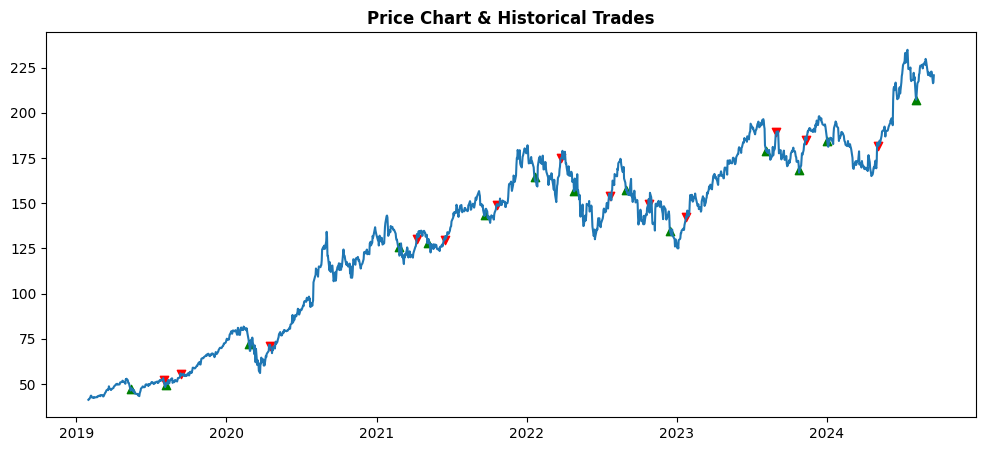

In [10]:
a=instance.plot_chart()
type(a)

In [11]:
pip install dash



[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [12]:
from dash import Dash,Input, Output, dcc, html,callback, dash_table
import io
import base64
import plotly.express as px
import plotly.graph_objects as go

In [13]:
tickers=pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0].Symbol

In [14]:
list(tickers)

['MMM',
 'AOS',
 'ABT',
 'ABBV',
 'ACN',
 'ADBE',
 'AMD',
 'AES',
 'AFL',
 'A',
 'APD',
 'ABNB',
 'AKAM',
 'ALB',
 'ARE',
 'ALGN',
 'ALLE',
 'LNT',
 'ALL',
 'GOOGL',
 'GOOG',
 'MO',
 'AMZN',
 'AMCR',
 'AEE',
 'AAL',
 'AEP',
 'AXP',
 'AIG',
 'AMT',
 'AWK',
 'AMP',
 'AME',
 'AMGN',
 'APH',
 'ADI',
 'ANSS',
 'AON',
 'APA',
 'AAPL',
 'AMAT',
 'APTV',
 'ACGL',
 'ADM',
 'ANET',
 'AJG',
 'AIZ',
 'T',
 'ATO',
 'ADSK',
 'ADP',
 'AZO',
 'AVB',
 'AVY',
 'AXON',
 'BKR',
 'BALL',
 'BAC',
 'BK',
 'BBWI',
 'BAX',
 'BDX',
 'BRK.B',
 'BBY',
 'BIO',
 'TECH',
 'BIIB',
 'BLK',
 'BX',
 'BA',
 'BKNG',
 'BWA',
 'BSX',
 'BMY',
 'AVGO',
 'BR',
 'BRO',
 'BF.B',
 'BLDR',
 'BG',
 'BXP',
 'CHRW',
 'CDNS',
 'CZR',
 'CPT',
 'CPB',
 'COF',
 'CAH',
 'KMX',
 'CCL',
 'CARR',
 'CTLT',
 'CAT',
 'CBOE',
 'CBRE',
 'CDW',
 'CE',
 'COR',
 'CNC',
 'CNP',
 'CF',
 'CRL',
 'SCHW',
 'CHTR',
 'CVX',
 'CMG',
 'CB',
 'CHD',
 'CI',
 'CINF',
 'CTAS',
 'CSCO',
 'C',
 'CFG',
 'CLX',
 'CME',
 'CMS',
 'KO',
 'CTSH',
 'CL',
 'CMCSA',
 'CAG'

In [30]:
from dash import Dash, html, dcc, callback, Output, Input
import dash_table
import yfinance as yf
import plotly.express as px
import plotly.graph_objects as go
import pandas as pd

class Backtest:
    def __init__(self, symbol):
        self.symbol = symbol
        if symbol:  # Check if symbol is not None
            self.df = yf.download(self.symbol, start='2019-01-01')
            self.df.reset_index(inplace=True)  # Reset index to get 'Date' as a column
            # For demonstration, create dummy sell_date and buy_date
            self.df['sell_date'] = pd.NaT  # Placeholder for sell_date
            self.df['buy_date'] = pd.NaT   # Placeholder for buy_date
            # Here you can implement your logic to set the sell_date and buy_date
            self.df.loc[::10, 'sell_date'] = self.df['Date']  # Example: sell every 10th day
            self.df.loc[::15, 'buy_date'] = self.df['Date']   # Example: buy every 15th day
        else:
            self.df = None

    def backtest_dataframe(self):
        # Implement your logic to create the backtest dataframe
        # Return two DataFrames as expected by your callback
        metrics_df = pd.DataFrame({
            'Metric': ['Total Return', 'Sharpe Ratio'],
            'Value': [0.15, 1.2]  # Example metrics
        })
        execution_df = pd.DataFrame({
            'Trade': ['Buy', 'Sell'],
            'Count': [10, 5]  # Example execution counts
        })
        return metrics_df, execution_df

# Create a Dash app
app = Dash(__name__)

# Example list of tickers, replace with your actual list
tickers = ["AAPL", "SQ"]  # Example tickers, replace with your actual list

app.layout = html.Div([
    html.H1('Mean Reversion - Stock Screener'),

    html.Div([
        dcc.Dropdown(id="stock_name", options=[{"label": ticker, "value": ticker} for ticker in tickers], placeholder="Select a Stock"),

        html.Br(),
        html.H4("Strategy Performance", id="heading1", style={"display": "None"}),
        html.Br(),
        html.Div([], id="metrics_table"),

        html.Br(),
        html.H4("Strategy Execution", id="heading2", style={"display": "None"}),
        html.Br(),
        html.Div([], id="execution_table"),
        html.Br(),
        dcc.Graph(id='plot'),

    ])
])

@callback(
    Output(component_id='heading1', component_property='style'),
    Output(component_id='heading2', component_property='style'),
    Output(component_id='metrics_table', component_property='children'),
    Output(component_id='execution_table', component_property='children'),
    Input(component_id='stock_name', component_property='value')
)
def update_output_div(input_value):
    if input_value is None:
        return {"display": "none"}, {"display": "none"}, [], []  # Hide all components

    instance = Backtest(input_value)
    a, b = instance.backtest_dataframe()

    metrics_table = dash_table.DataTable(
        data=a.to_dict('records'),
        columns=[{"name": i, "id": i} for i in a.columns],
        style_header={
            'backgroundColor': 'rgb(240,248,255)',
            'color': 'black',
            'fontWeight': 'bold'
        },
        style_cell_conditional=[{'if': {'column_id': c}, 'textAlign': 'center'} for c in a.columns],
    )

    execution_table = dash_table.DataTable(
        data=b.to_dict('records'),
        columns=[{"name": i, "id": i} for i in b.columns],
        style_header={
            'backgroundColor': 'rgb(240,248,255)',
            'color': 'black',
            'fontWeight': 'bold',
            'textAlign': 'center'
        },
        style_data_conditional=[{'if': {'row_index': 'even'}, 'textAlign': 'center'},
                                {'if': {'row_index': 'odd'}, 'textAlign': 'center'}],
    )

    return {"display": "block"}, {"display": "block"}, metrics_table, execution_table


@app.callback(
    Output('plot', 'figure'),
    [Input('stock_name', 'value')]
)
def update_figure(input_values):
    if input_values is None:
        return go.Figure()  # Return an empty figure if no stock is selected

    instance = Backtest(input_values)
    df = instance.df

    if df is None or df.empty:
        return go.Figure()  # Return an empty figure if no data is available

    fig = px.line(df, x="Date", y="Close", title=f"Stock Prices for {input_values}")

    # Assuming 'sell_date' and 'buy_date' are in datetime format or can be cast to it
    x_data = []
    y_data = []
    for i in range(len(df)):
        if pd.notna(df['sell_date'][i]):  # Check if sell_date is not NaT
            x_data.append(df['sell_date'][i])
            y_data.append(df['Close'][i])

    fig.add_trace(go.Scatter(x=x_data, y=y_data, mode='markers', name='Sell', marker=dict(size=10)))

    x_data = []
    y_data = []
    for i in range(len(df)):
        if pd.notna(df['buy_date'][i]):  # Check if buy_date is not NaT
            x_data.append(df['buy_date'][i])
            y_data.append(df['Close'][i])

    fig.add_trace(go.Scatter(x=x_data, y=y_data, mode='markers', name='Buy', marker=dict(size=10)))

    return fig


if __name__ == '__main__':
    app.run_server(debug=True, host='127.0.0.1', port=8055)


[*********************100%%**********************]  1 of 1 completed



---------------------------------------------------------------------------
AttributeError                            Traceback (most recent call last)
Cell In[30], line 74, in update_output_div(input_value='AAPL')
     71 if input_value is None:
     72     return {"display": "none"}, {"display": "none"}, [], []  # Hide all components
---> 74 instance = Backtest(input_value)
        instance = <__main__.Backtest object at 0x000001E1BB3A5AB0>
        input_value = 'AAPL'
     75 a, b = instance.backtest_dataframe()
     77 metrics_table = dash_table.DataTable(
     78     data=a.to_dict('records'),
     79     columns=[{"name": i, "id": i} for i in a.columns],
   (...)
     85     style_cell_conditional=[{'if': {'column_id': c}, 'textAlign': 'center'} for c in a.columns],
     86 )

Cell In[30], line 12, in Backtest.__init__(
    self=<__main__.Backtest object>,
    symbol='AAPL'
)
     10 self.symbol = symbol
     11 if symbol:  # Check if symbol is not None
---> 12     self.df = yf.d

[*********************100%%**********************]  1 of 1 completed



---------------------------------------------------------------------------
AttributeError                            Traceback (most recent call last)
Cell In[30], line 112, in update_figure(input_values='SQ')
    109 if input_values is None:
    110     return go.Figure()  # Return an empty figure if no stock is selected
--> 112 instance = Backtest(input_values)
        instance = <__main__.Backtest object at 0x000001E1BB3A5AB0>
        input_values = 'SQ'
    113 df = instance.df
    115 if df is None or df.empty:

Cell In[30], line 12, in Backtest.__init__(
    self=<__main__.Backtest object>,
    symbol='SQ'
)
     10 self.symbol = symbol
     11 if symbol:  # Check if symbol is not None
---> 12     self.df = yf.download(self.symbol, start='2019-01-01')
        self.symbol = 'SQ'
        self = <__main__.Backtest object at 0x000001E1C79B1360>
        yf.download = <function log_indent_decorator.<locals>.wrapper at 0x000001E1BA6E0AF0>
        yf = <module 'yfinance' from 'C:\\Users

[*********************100%%**********************]  1 of 1 completed



---------------------------------------------------------------------------
AttributeError                            Traceback (most recent call last)
Cell In[30], line 112, in update_figure(input_values='SQ')
    109 if input_values is None:
    110     return go.Figure()  # Return an empty figure if no stock is selected
--> 112 instance = Backtest(input_values)
        instance = <__main__.Backtest object at 0x000001E1BB3A5AB0>
        input_values = 'SQ'
    113 df = instance.df
    115 if df is None or df.empty:

Cell In[30], line 12, in Backtest.__init__(
    self=<__main__.Backtest object>,
    symbol='SQ'
)
     10 self.symbol = symbol
     11 if symbol:  # Check if symbol is not None
---> 12     self.df = yf.download(self.symbol, start='2019-01-01')
        self.symbol = 'SQ'
        self = <__main__.Backtest object at 0x000001E1C793EB90>
        yf.download = <function log_indent_decorator.<locals>.wrapper at 0x000001E1BA6E0AF0>
        yf = <module 'yfinance' from 'C:\\Users

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


---------------------------------------------------------------------------
AttributeError                            Traceback (most recent call last)
Cell In[30], line 74, in update_output_div(input_value='AAPL')
     71 if input_value is None:
     72     return {"display": "none"}, {"display": "none"}, [], []  # Hide all components
---> 74 instance = Backtest(input_value)
        instance = <__main__.Backtest object at 0x000001E1BB3A5AB0>
        input_value = 'AAPL'
     75 a, b = instance.backtest_dataframe()
     77 metrics_table = dash_table.DataTable(
     78     data=a.to_dict('records'),
     79     columns=[{"name": i, "id": i} for i in a.columns],
   (...)
     85     style_cell_conditional=[{'if': {'column_id': c}, 'textAlign': 'center'} for c in a.columns],
     86 )

Cell In[30], line 12, in Backtest.__init__(
    self=<__main__.Backtest object>,
    symbol='AAPL'
)
     10 self.symbol = symbol
     11 if symbol:  # Check if symbol is not None
---> 12     self.df = yf.d

[*********************100%%**********************]  1 of 1 completed



---------------------------------------------------------------------------
AttributeError                            Traceback (most recent call last)
Cell In[30], line 74, in update_output_div(input_value='SQ')
     71 if input_value is None:
     72     return {"display": "none"}, {"display": "none"}, [], []  # Hide all components
---> 74 instance = Backtest(input_value)
        instance = <__main__.Backtest object at 0x000001E1BB3A5AB0>
        input_value = 'SQ'
     75 a, b = instance.backtest_dataframe()
     77 metrics_table = dash_table.DataTable(
     78     data=a.to_dict('records'),
     79     columns=[{"name": i, "id": i} for i in a.columns],
   (...)
     85     style_cell_conditional=[{'if': {'column_id': c}, 'textAlign': 'center'} for c in a.columns],
     86 )

Cell In[30], line 12, in Backtest.__init__(
    self=<__main__.Backtest object>,
    symbol='SQ'
)
     10 self.symbol = symbol
     11 if symbol:  # Check if symbol is not None
---> 12     self.df = yf.downloa